In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive")

# Version

*   Tensorflow: 2.2.0
*   Keras: 2.3.1



In [ ]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 50.8MB/s 
     |████████████████████████████████| 460kB 23.6MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 4.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


---
# Preprocess


1.   Picture format conversion 

In [ ]:
import os
from PIL import Image

def bmpToPng(file_path,new_file_path1,new_file_path2):
    n = 0
    files = os.listdir(file_path)
    files.sort()
    for fileName in files:
        # print(fileName)
        #newFileName = fileName[0:fileName.find(".")]+".png"
        newFileName = fileName
        im = Image.open(file_path+"/"+fileName)
        if(n <40):
          im.save(new_file_path1+"/"+newFileName)
          n = n+1
        else:
          im.save(new_file_path2+"/"+newFileName)
          n = n+1


file_path = "./4data/drishti train/image"
new_file_path1 = "./4data/Training/image for cup"
new_file_path2= "./4data/Validation/image for cup"
bmpToPng(file_path,new_file_path1,new_file_path2)


2.   Resize 



In [ ]:
from PIL import Image
import os.path
import glob
def convert(file,outdir,width=1940,height=1940):
    img=Image.open(file)
    try:
        new_img=img.resize((width,height),Image.BILINEAR)   
        new_img.save(os.path.join(outdir,os.path.basename(file)))
    except Exception as e:
        print(e)
for file in glob.glob("./submit/complete_50/*.png"):
    print(file)
    convert(file,"./submit/segmentation/")

# Install segmentation models

In [ ]:
!pip install segmentation-models

# **Segmentation Training** 


*   Optimizer = Adam(lr = 1e-4)
*   Loss: BinaryFocalLoss+dice loss
*   Batch_size = 10




In [ ]:
import os
import cv2
import segmentation_models as sm
import tensorflow as tf
import keras.utils
import numpy as np
from PIL import Image
from keras.optimizers import adam
MAX_EPOCHS = 20
image_size = 256
#BACKBONE = 'densenet169'
#BACKBONE = 'efficientnetb0'
#BACKBONE = 'resnet34'
BACKBONE = 'seresnext101'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
class Data_Gen(keras.utils.Sequence):

  def __init__(self, batch_size, x_set, y_set):
      self.x, self.y = np.array(x_set), np.array(y_set)
      self.batch_size = batch_size
      #self.indices=np.arange(len(x_set))
      self.indices = np.arange(self.x.shape[0])
      np.random.shuffle(self.indices)
      #self.type = type
      #self.preproc = preproc

  def __len__(self):
      # print(self.type + ' - len : ' + str(int(np.ceil(self.x.shape[0] / self.batch_size))))
      return int(np.ceil(self.x.shape[0] / self.batch_size))

  def __getitem__(self, idx):
      #inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
      upper_bound = len(self.indices) if ((idx + 1) * self.batch_size) > len(self.indices)  else (idx + 1) * self.batch_size    
      inds = self.indices[idx * self.batch_size:upper_bound]
      batch_x = np.empty((len(inds),image_size,image_size,3))  
      batch_y = np.empty((len(inds),image_size,image_size,1))
      for i in range(len(inds)):
        image_x = cv2.imread(self.x[inds[i]]) 
        imx = cv2.resize(image_x, (image_size,image_size), interpolation=cv2.INTER_CUBIC)
        imagex = np.zeros(imx.shape,dtype = np.float32)
        cv2.normalize(imx,imagex,alpha = 0,beta = 1,norm_type = cv2.NORM_MINMAX,dtype = cv2.CV_32F)  
        batch_x[i] = cv2.cvtColor(imagex,cv2.COLOR_BGR2RGB)  
        mask_y = cv2.imread(self.y[inds[i]],cv2.IMREAD_GRAYSCALE)/255 
        msy = cv2.resize(mask_y, (image_size,image_size))
        msy = np.expand_dims(msy, axis=2)
        batch_y[i] = msy
        #mask_y = cv2.imread(self.y[inds[i]]) 
        #msy = cv2.resize(mask_y, (image_size,image_size), interpolation=cv2.INTER_CUBIC)
        #masky = np.zeros(msy.shape,dtype = np.float32)
        #cv2.normalize(msy,masky,alpha = 0,beta = 1,norm_type = cv2.NORM_MINMAX,dtype = cv2.CV_32F) 
        #batch_y[i] = cv2.cvtColor(masky,cv2.COLOR_BGR2RGB) 
      return batch_x, batch_y

  def on_epoch_end(self):
      np.random.shuffle(self.indices)

In [ ]:
def preProcess(flag,path,type):
  if (flag =="disc"):
    new_path = os.path.join('./refuge+drishti',type,'mask_disc')
    os.makedirs(new_path)
    i = 1
    j = 1
    filePath = path
    fileList = os.listdir(filePath)
    fileList.sort()
    for file in fileList:
      print(file)
      img = Image.open(os.path.join(filePath,file))
      width = img.size[0]#长度
      height = img.size[1]#宽度
      for i in range(0,width):#遍历所有长度的点
          for j in range(0,height):#遍历所有宽度的点
              data = (img.getpixel((i,j)))
              if ((data==255)):
                  img.putpixel((i, j), 255) 
              else:
                  img.putpixel((i, j), 128) 
      img.save(os.path.join(new_path,file))
  if (flag =="cup"):
    new_path = os.path.join('./refuge+drishti',type,'mask_cup')
    os.makedirs(new_path)
    i = 1
    j = 1
    filePath = path
    fileList = os.listdir(filePath)
    fileList.sort()
    for file in fileList:
      print(file)
      img = Image.open(os.path.join(filePath,file))
      width = img.size[0]#长度
      height = img.size[1]#宽度
      for i in range(0,width):#遍历所有长度的点
          for j in range(0,height):#遍历所有宽度的点
              data = (img.getpixel((i,j)))
              if ((data==0)):
                  img.putpixel((i, j), 0) 
              else:
                  img.putpixel((i, j), 255)  
      img.save(os.path.join(new_path,file))
  return new_path

flag = "cup"

In [ ]:
batch_size = 10


images_dir = os.path.join('./4data/Training/', 'image for disc')
masks_dir = os.path.join('./4data/Training/', 'mask_disc')
#masks_dir = preProcess(flag,masks_dir,'Training')
#print(masks_dir)
ids = os.listdir(images_dir)
ids.sort()
images_fps  = [os.path.join(images_dir, image_id) for image_id in ids]
print(images_fps)
idms = os.listdir(masks_dir)
idms.sort()
masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in idms]
print(masks_fps)

test_images_dir = os.path.join('./4data/Validation/', 'image for disc')
test_masks_dir = os.path.join('./4data/Validation/', 'mask_disc')
#test_masks_dir = preProcess(flag,test_masks_dir,'Validation')
#print(test_masks_dir)
ids = os.listdir(test_images_dir)
ids.sort()
test_images_fps  = [os.path.join(test_images_dir, image_id) for image_id in ids]
print(test_images_fps)
idms = os.listdir(test_masks_dir)
idms.sort()
test_masks_fps = [os.path.join(test_masks_dir, mask_id) for mask_id in idms]
print(test_masks_fps)

train_gen = Data_Gen(batch_size, images_fps, masks_fps)
val_gen = Data_Gen(batch_size, test_images_fps,test_masks_fps)

['./4data/Training/image for disc/H0001.jpg', './4data/Training/image for disc/H0002.jpg', './4data/Training/image for disc/H0003.jpg', './4data/Training/image for disc/H0004.jpg', './4data/Training/image for disc/H0005.jpg', './4data/Training/image for disc/H0006.jpg', './4data/Training/image for disc/H0007.jpg', './4data/Training/image for disc/H0008.jpg', './4data/Training/image for disc/H0009.jpg', './4data/Training/image for disc/H0010.jpg', './4data/Training/image for disc/H0011.jpg', './4data/Training/image for disc/H0012.jpg', './4data/Training/image for disc/H0013.jpg', './4data/Training/image for disc/H0014.jpg', './4data/Training/image for disc/H0015.jpg', './4data/Training/image for disc/H0016.jpg', './4data/Training/image for disc/H0017.jpg', './4data/Training/image for disc/H0018.jpg', './4data/Training/image for disc/H0019.jpg', './4data/Training/image for disc/H0020.jpg', './4data/Training/image for disc/H0021.jpg', './4data/Training/image for disc/H0022.jpg', './4data/

# **Unet**
**image size = 256**

In [ ]:
!git clone https://github.com/qubvel/segmentation_models.git

Cloning into 'segmentation_models'...
remote: Enumerating objects: 922, done.
remote: Total 922 (delta 0), reused 0 (delta 0), pack-reused 922
Receiving objects: 100% (922/922), 1.81 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (518/518), done.


In [ ]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing

import sys
sys.path.append('/content/drive/My Drive/segmentation_models/segmentation_models')

**First training on disc**

In [ ]:
from segmentation_models import losses
from segmentation_models import metrics

opt = adam(lr = 0.0001)
model = Unet(BACKBONE, encoder_weights='imagenet')
#set_trainable(model)
model.compile(optimizer = opt, 
              loss = losses.binary_focal_dice_loss,
              metrics = [metrics.f1_score])
model_checkpoint = keras.callbacks.ModelCheckpoint('./segWeight_disc/weight_seg_unet_seres101_bfdl_1st.hdf5', 
                                                   monitor="val_loss", 
                                                   mode="min", verbose=1, 
                                                   save_best_only=True)
history = model.fit_generator(train_gen,
                              epochs=MAX_EPOCHS,
                              validation_data=val_gen,
                              callbacks=[model_checkpoint])

Epoch 1/20
143/143 [==============================] - 1832s 13s/step - loss: 0.2010 - f1-score: 0.8209 - val_loss: 0.1835 - val_f1-score: 0.8262

Epoch 00001: val_loss improved from inf to 0.18348, saving model to ./segWeight_disc/weight_seg_unet_seres101_bfdl_1st.hdf5
Epoch 2/20
143/143 [==============================] - 277s 2s/step - loss: 0.0867 - f1-score: 0.9181 - val_loss: 0.0861 - val_f1-score: 0.9165

Epoch 00002: val_loss improved from 0.18348 to 0.08612, saving model to ./segWeight_disc/weight_seg_unet_seres101_bfdl_1st.hdf5
Epoch 3/20
 80/143 [===============>..............] - ETA: 1:33 - loss: 0.0618 - f1-score: 0.9418

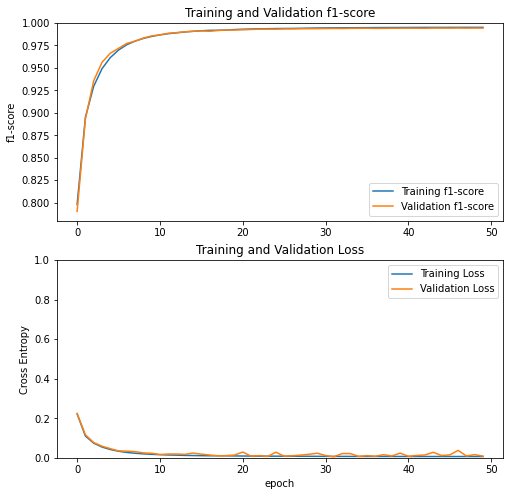

In [ ]:
from matplotlib import pyplot as plt
f1score = history.history['f1-score']
val_f1score = history.history['val_f1-score']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1score, label='Training f1-score')
plt.plot(val_f1score, label='Validation f1-score')
plt.legend(loc='lower right')
plt.ylabel('f1-score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1-score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Second training on cup**

In [ ]:
from segmentation_models import losses
from segmentation_models import metrics

opt = adam(lr = 0.0001)
model = Unet(BACKBONE, encoder_weights='imagenet')
#set_trainable(model)
model.compile(optimizer = opt, 
              loss = losses.binary_focal_dice_loss,
              metrics = [metrics.f1_score])
model_checkpoint = keras.callbacks.ModelCheckpoint('./segWeight_cup/weight_seg_unet_se154_bfdl_2nd.hdf5', 
                                                   monitor="val_loss", 
                                                   mode="min", verbose=1, 
                                                   save_best_only=True)
history = model.fit_generator(train_gen,
                              epochs=MAX_EPOCHS,
                              validation_data=val_gen,
                              callbacks=[model_checkpoint])

Epoch 1/20


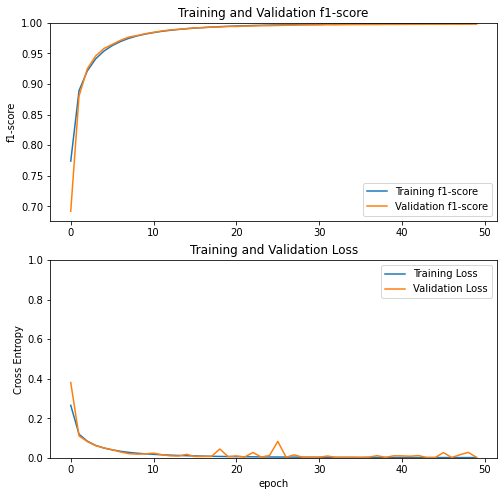

In [ ]:
from matplotlib import pyplot as plt
f1score = history.history['f1-score']
val_f1score = history.history['val_f1-score']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(f1score, label='Training f1-score')
plt.plot(val_f1score, label='Validation f1-score')
plt.legend(loc='lower right')
plt.ylabel('f1-score')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1-score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **FPN**


**Image size = 256**


**First training on disc**

In [ ]:
from segmentation_models import FPN
from segmentation_models import get_preprocessing
from segmentation_models.utils import set_trainable
from focal_loss import BinaryFocalLoss

#loss_func = BinaryFocalLoss(gamma=2)
opt = adam(lr = 0.0001)
model = FPN(BACKBONE, classes=1,encoder_weights='imagenet')
#set_trainable(model)
model.compile(optimizer = opt, 
              #loss = loss_func,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

model_checkpoint = keras.callbacks.ModelCheckpoint('./segWeight/weight_seg_FPN_50_1st.hdf5', 
                                                   monitor="val_loss", 
                                                   mode="min", verbose=1, 
                                                   save_best_only=True)
history = model.fit_generator(train_gen,
                    epochs=MAX_EPOCHS,
                    validation_data=val_gen,
                    callbacks=[model_checkpoint])

Epoch 1/20
  2/139 [..............................] - ETA: 32:45 - loss: 0.1257 - accuracy: 0.9831  

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 57 could not be retrieved. It could be because a worker has died.
  UserWarning)


  3/139 [..............................] - ETA: 1:01:57 - loss: 0.1242 - accuracy: 0.9833

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 120 could not be retrieved. It could be because a worker has died.
  UserWarning)


 99/139 [====================>.........] - ETA: 5:31 - loss: 0.1329 - accuracy: 0.9821

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


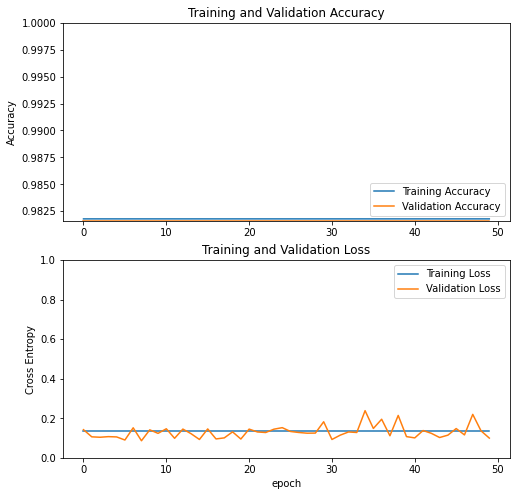

In [ ]:
from matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Image size = 256**


**Second training on cup**

In [ ]:
from segmentation_models import FPN
from segmentation_models import get_preprocessing
from segmentation_models.utils import set_trainable

opt = adam(lr = 0.0001)
model = FPN(BACKBONE, classes=1,encoder_weights='imagenet')
#set_trainable(model)
model.compile(optimizer = opt, loss = 'binary_crossentropy',metrics=['accuracy'])

model_checkpoint = keras.callbacks.ModelCheckpoint('./segWeight/weight_seg_FPN_50_2nd.hdf5', 
                                                   monitor="val_loss", 
                                                   mode="min", verbose=1, 
                                                   save_best_only=True)
history = model.fit_generator(train_gen,
                    epochs=MAX_EPOCHS,
                    validation_data=val_gen,
                    callbacks=[model_checkpoint])

Epoch 1/50
100/100 [==============================] - 730s 7s/step - loss: 0.0872 - accuracy: 0.9940 - val_loss: 0.0477 - val_accuracy: 0.9945

Epoch 00001: val_loss improved from inf to 0.04765, saving model to ./segWeight/weight_seg_FPN_50_2nd.hdf5
Epoch 2/50
100/100 [==============================] - 87s 866ms/step - loss: 0.0872 - accuracy: 0.9940 - val_loss: 0.0556 - val_accuracy: 0.9945

Epoch 00002: val_loss did not improve from 0.04765
Epoch 3/50
100/100 [==============================] - 83s 827ms/step - loss: 0.0872 - accuracy: 0.9940 - val_loss: 0.0543 - val_accuracy: 0.9945

Epoch 00003: val_loss did not improve from 0.04765
Epoch 4/50
100/100 [==============================] - 83s 831ms/step - loss: 0.0872 - accuracy: 0.9940 - val_loss: 0.0624 - val_accuracy: 0.9945

Epoch 00004: val_loss did not improve from 0.04765
Epoch 5/50
100/100 [==============================] - 82s 824ms/step - loss: 0.0872 - accuracy: 0.9940 - val_loss: 0.0637 - val_accuracy: 0.9945

Epoch 00005:

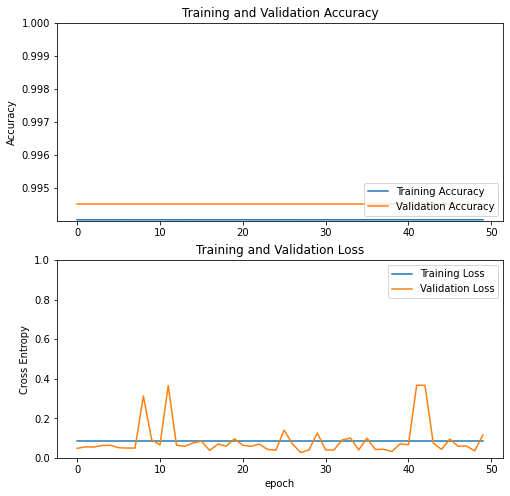

In [ ]:
from matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Segmentation Predict**


In [ ]:
import skimage.io as io
from segmentation_models import Unet
from segmentation_models import FPN
from segmentation_models import get_preprocessing
import os
import cv2
import segmentation_models as sm
import tensorflow as tf
import keras
import numpy as np
from keras.optimizers import adam

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

image_size = 256

def testGenerator(name,test_path):
        img = np.empty((1,image_size,image_size,3))
        path = os.path.join(test_path,"%s.jpg"%name)
        image =cv2.imread(path)
        im = cv2.resize(image, (image_size,image_size), interpolation=cv2.INTER_CUBIC)
        ima = np.zeros(im.shape,dtype = np.float32)
        cv2.normalize(im,ima,alpha = 0,beta = 1,norm_type = cv2.NORM_MINMAX,dtype = cv2.CV_32F)
        img[0] = cv2.cvtColor(ima,cv2.COLOR_BGR2RGB)
        yield img

def labelVisualize(num_class,color_dict,img):
    print(img.shape)
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    
    return img_out / 255

def saveResult(name,save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        output = cv2.resize(img, (1940,1940))
        io.imsave(os.path.join(save_path,"%s.png"%name),output)

        
#VALIDATION FOLDER
file_path = "./dataset/Refuge2-Validation/Refuge2-Validation"


In [ ]:

#PREDICT DISC
predict_path = "./segResult/segmentation_unet_disc"
model =  Unet(BACKBONE, encoder_weights='imagenet',classes =1)
model.load_weights("./segWeight/weight_seg_unet_res34_bfdl_1st.hdf5")
files = os.listdir(file_path)
files.sort()
for fileName in files:
  newFileName = fileName[0:fileName.find(".")]    
  testGene = testGenerator(newFileName,file_path)
  results = model.predict_generator(testGene,1,verbose=1)
  saveResult(newFileName,predict_path,results)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 592ms/step


1/1 [==============================] - 1s 503ms/step


1/1 [==============================] - 1s 513ms/step


1/1 [==============================] - 1s 619ms/step


1/1 [==============================] - 1s 581ms/step


1/1 [==============================] - 0s 451ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 1s 505ms/step


KeyboardInterrupt: ignored

In [ ]:
import skimage.io as io
from segmentation_models import Unet
from segmentation_models import FPN
from segmentation_models import get_preprocessing
import os
import cv2
import segmentation_models as sm
import tensorflow as tf
import keras
import numpy as np
from keras.optimizers import adam

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

image_size = 256

def testGenerator(name,test_path):
        img = np.empty((1,image_size,image_size,3))
        path = os.path.join(test_path,"%s.jpg"%name)
        image =cv2.imread(path)
        im = cv2.resize(image, (image_size,image_size), interpolation=cv2.INTER_CUBIC)
        ima = np.zeros(im.shape,dtype = np.float32)
        cv2.normalize(im,ima,alpha = 0,beta = 1,norm_type = cv2.NORM_MINMAX,dtype = cv2.CV_32F)
        img[0] = cv2.cvtColor(ima,cv2.COLOR_BGR2RGB)
        yield img

def labelVisualize(num_class,color_dict,img):
    print(img.shape)
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    
    return img_out / 255

def saveResult(name,save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        output = cv2.resize(img, (1940,1940))
        io.imsave(os.path.join(save_path,"%s.png"%name),output)

        
#VALIDATION FOLDER
file_path = "./dataset/Refuge2-Validation/Refuge2-Validation"


In [ ]:

#PREDICT DISC
predict_path = "./segResult/segmentation_unet_cup"
model =  Unet(BACKBONE, encoder_weights='imagenet',classes =1)
model.load_weights("./segWeight/weight_seg_unet_effb0_bfdl_2nd.hdf5")
files = os.listdir(file_path)
files.sort()
for fileName in files:
  newFileName = fileName[0:fileName.find(".")]    
  testGene = testGenerator(newFileName,file_path)
  results = model.predict_generator(testGene,1,verbose=1)
  saveResult(newFileName,predict_path,results)

In [ ]:
import os
import numpy as np
import imageio

import cv2

i = 1
j = 1
filePath = './segResult/segmentation_unet_cup'
fileList = os.listdir(filePath)
fileList.sort()
for file in fileList:
    print(file)

    # img_cup = imageio.imread(os.path.join(filePath, file))
    # img_disk = imageio.imread(os.path.join('./segmentations/segmentation_unet_disc', file))
    img_cup = cv2.imread(os.path.join(filePath, file), cv2.IMREAD_GRAYSCALE)
    img_disk = cv2.imread(os.path.join('./segResult/segmentation_unet_disc', file), cv2.IMREAD_GRAYSCALE)


    width = img_cup.shape[0]
    height = img_cup.shape[1]

    img_result = np.zeros((width, height))
    img_result[:, :] = 255

    for i in range(0, width):
        for j in range(0, height):

            pixel_cup = img_cup[i][j]
            pixel_disk = img_disk[i][j]

            if pixel_disk < 200:
                img_result[i][j] = 128
                if pixel_cup < 100:
                    img_result[i][j] = 0

    cv2.imwrite(os.path.join('./segResult/seg', file), img_result)

V0001.png
V0002.png
V0003.png
V0004.png
V0005.png
V0006.png
V0007.png
V0008.png
V0009.png
V0010.png
V0011.png
V0012.png
V0013.png
V0014.png
V0015.png
V0016.png
V0017.png
V0018.png
V0019.png
V0020.png
V0021.png
V0022.png
V0023.png
V0024.png
V0025.png
V0026.png
V0027.png
V0028.png
V0029.png
V0030.png
V0031.png
V0032.png
V0033.png
V0034.png
V0035.png
V0036.png
V0037.png
V0038.png
V0039.png
V0040.png
V0041.png
V0042.png
V0043.png
V0044.png
V0045.png
V0046.png
V0047.png
V0048.png
V0049.png
V0050.png
V0051.png
V0052.png
V0053.png
V0054.png
V0055.png
V0056.png
V0057.png
V0058.png
V0059.png
V0060.png
V0061.png
V0062.png
V0063.png
V0064.png
V0065.png
V0066.png
V0067.png
V0068.png
V0069.png
V0070.png
V0071.png
V0072.png
V0073.png
V0074.png
V0075.png
V0076.png
V0077.png
V0078.png
V0079.png
V0080.png
V0081.png
V0082.png
V0083.png
V0084.png
V0085.png
V0086.png
V0087.png
V0088.png
V0089.png
V0090.png
V0091.png
V0092.png
V0093.png
V0094.png
V0095.png
V0096.png
V0097.png
V0098.png
V0099.png
V0100.png




---


# **ROI Segmentation**

In [ ]:
import cv2
import numpy

image_name = "T0001"
image_path = "./data/test"
path = os.path.join(image_path,"%s.png"%image_name)
image = cv2.imread(path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
print(image.shape)
print(image.size)

(512, 512, 3)
786432


In [ ]:
mask_name = "T0001_predict"
mask_path = "./data/test"
path = os.path.join(mask_path,"%s.png"%mask_name)
mask = cv2.imread(path)
mask = cv2.cvtColor(mask,cv2.IMREAD_GRAYSCALE)
print(mask.shape)
print(mask.size)

(512, 512, 4)
1048576


**Single image for test**

*   Input: full pathes of image and mask 
*   Output: ROI and image with highlight



In [ ]:
import numpy as np
import cv2
import math

original_mask = cv2.imread("./data/result_test/T0358_predict.png")
original_image = cv2.imread("./data/refuge_data/test set/image/T0358.png")
mask = original_mask.copy()
image = original_image.copy()
gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)

# Find contours in the image
cnts = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Obtain area for each contour
contour_sizes = [(cv2.contourArea(contour), contour) for contour in cnts]

# Find maximum contour and crop for ROI section
if len(contour_sizes) > 0:
    largest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    x,y,w,h = cv2.boundingRect(largest_contour)
    print(x,y,w,h)
    H = int(round((256-h)/2))
    W = int(round((256-w)/2))
    print(H,W)
    if((x-W) < 0):
      x = W
      print(x,y,w,h)
    cv2.rectangle(image, (x-W, y-H), (x+256-W, y+256-H), (36,255,12), 2)
    ROI = original_image[y-H:y+256-H, x-W:x+256-W]
    #ROI = cv2.resize(ROI,(512,512), interpolation=cv2.INTER_CUBIC) 
    #cv2.imshow("ROI", ROI) 
    cv2.imwrite('./data/test/ROI1.png', ROI, [cv2.IMWRITE_PNG_COMPRESSION, 0])

    
#cv2.imshow("canny", canny) 
#cv2.imwrite('./data/test/canny.png', canny, [cv2.IMWRITE_PNG_COMPRESSION, 0])
#cv2.imshow("detected", mask) 
cv2.imwrite('./data/test/detected1.png', image, [cv2.IMWRITE_PNG_COMPRESSION, 0])
cv2.imwrite('./data/test/blurred1.png',blurred, [cv2.IMWRITE_PNG_COMPRESSION, 0])
#cv2.waitKey(0)

16 177 80 84
86 88
88 177 80 84


True

**ROI Segmentation for multi images**

*   Input: pathes of images and masks folders
*   Output: ROIs and images with highlight

In [ ]:
import numpy as np
import cv2

def ROIsegement(mask_path,image_path,mask_name):
  image_name = mask_name[0:mask_name.find("_")]+".png"
  images_dir = os.path.join(image_path, image_name)
  masks_dir = os.path.join(mask_path, mask_name)
  original_mask = cv2.imread(masks_dir)
  original_image = cv2.imread(images_dir)
  mask = original_mask.copy()
  image = original_image.copy()
  gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (3, 3), 0)
  canny = cv2.Canny(blurred, 120, 255, 1)

  # Find contours in the image
  cnts = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  # Obtain area for each contour
  contour_sizes = [(cv2.contourArea(contour), contour) for contour in cnts]

  # Find maximum contour and crop for ROI section
  if len(contour_sizes) > 0:
      largest_contour = max(contour_sizes, key=lambda x: x[0])[1]
      x,y,w,h = cv2.boundingRect(largest_contour)
      H = int(round((256-h)/2))
      W = int(round((256-w)/2))
      if((x-W) < 0):
        x = W
      cv2.rectangle(image, (x-W, y-H), (x+256-W, y+256-H), (36,255,12), 2)
      #ROI = original_image[y-H:y+256-H, x-W:x+256-W]
      ROI = original_mask[y-H:y+256-H, x-W:x+256-W]
      #ROI = cv2.resize(ROI,(512,512), interpolation=cv2.INTER_CUBIC) 
      ROI_name = mask_name[0:mask_name.find("_")]+"_ROI.png"
      ROI_dir = os.path.join("./data/ROI_val_mask", ROI_name) 
      cv2.imwrite(ROI_dir, ROI, [cv2.IMWRITE_PNG_COMPRESSION, 0])

  #cv2.imwrite('./data/test/canny.png', canny, [cv2.IMWRITE_PNG_COMPRESSION, 0])
  detect_name = mask_name[0:mask_name.find("_")]+"_detect.png"
  detect_dir = os.path.join("./data/detect_val", detect_name)
  cv2.imwrite(detect_dir, image, [cv2.IMWRITE_PNG_COMPRESSION, 0])

In [ ]:
mask_path ="./data/result_val" 
image_path = "./data/refuge_data/val set/image"
for fileName in os.listdir(mask_path):
  print(fileName)
  ROIsegement(mask_path,image_path,fileName)
  print("finish %s"%fileName)

V0307_predict.png
finish V0307_predict.png
V0304_predict.png
finish V0304_predict.png
V0316_predict.png
finish V0316_predict.png
V0326_predict.png
finish V0326_predict.png
V0329_predict.png
finish V0329_predict.png
V0327_predict.png
finish V0327_predict.png
V0305_predict.png
finish V0305_predict.png
V0325_predict.png
finish V0325_predict.png
V0319_predict.png
finish V0319_predict.png
V0322_predict.png
finish V0322_predict.png
V0313_predict.png
finish V0313_predict.png
V0301_predict.png
finish V0301_predict.png
V0303_predict.png
finish V0303_predict.png
V0311_predict.png
finish V0311_predict.png
V0331_predict.png
finish V0331_predict.png
V0321_predict.png
finish V0321_predict.png
V0330_predict.png
finish V0330_predict.png
V0310_predict.png
finish V0310_predict.png
V0334_predict.png
finish V0334_predict.png
V0317_predict.png
finish V0317_predict.png
V0314_predict.png
finish V0314_predict.png
V0323_predict.png
finish V0323_predict.png
V0318_predict.png
finish V0318_predict.png
V0332_predi